<a href="https://colab.research.google.com/github/gmargonato/ML_Projects/blob/main/world_cup_2022_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022 FIFA's Soccer World Cup

Dataset: https://www.kaggle.com/datasets/shilongzhuang/soccer-world-cup-challenge

In [1]:
# Libraries
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

In [2]:
# Connection to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Acquisition
Loading the Datasets

In [3]:
# Load all datasets from folder

# Using glob to get all the csv files in the folder
path = "/content/drive/MyDrive/ML Projects/2022 World Cup/dataset"
csv_files = glob.glob(os.path.join(path, "*.csv")) 

# Dictionary with original datasets
d = {}

# Loop over the list of csv files
for file in csv_files:

    filename = (file.split("/")[-1]).split(".")[0]

    #Read the csv file
    d[filename] = pd.read_csv(file)

    #Print the file name and content
    print(filename)
    display(d[filename].tail())
    print()

world_cup_matches


,ID,Year,Date,Stage,Home Team,Home Goals,Away Goals,Away Team,Winning Team,Losing Team,Win Conditions,Host Team
895,896,2018,2018/7/7,Quarter-finals,Russia,2,2,Croatia,NaN,NaN,Croatia win on penalties (3 - 4),True
896,897,2018,2018/7/10,Semi-finals,France,1,0,Belgium,France,Belgium,NaN,False
897,898,2018,2018/7/11,Semi-finals,Croatia,2,1,England,Croatia,England,Extra time,False
898,899,2018,2018/7/14,Third place,Belgium,2,0,England,Belgium,England,NaN,False
899,900,2018,2018/7/15,Final,France,4,2,Croatia,France,Croatia,NaN,False



2022_world_cup_matches


,ID,Year,Date,Stage,Home Team,Away Team,Host Team
59,60,2022,2022/12/10,Quarter-finals,W55,W56,NaN
60,61,2022,2022/12/13,Semi-finals,W57,W58,NaN
61,62,2022,2022/12/14,Semi-finals,W59,W60,NaN
62,63,2022,2022/12/17,Third place,L61,L62,NaN
63,64,2022,2022/12/18,Final,W61,W62,NaN



world_cups


,Year,Host Country,Winner,Runners-Up,Third,Fourth,Goals Scored,Qualified Teams,Matches Played
17,2006,Germany,Italy,France,Germany,Portugal,147.0,32,64
18,2010,South Africa,Spain,Netherlands,Germany,Uruguay,145.0,32,64
19,2014,Brazil,Germany,Argentina,Netherlands,Brazil,171.0,32,64
20,2018,Russia,France,Croatia,Belgium,England,169.0,32,64
21,2022,Qatar,NaN,NaN,NaN,NaN,NaN,32,64



international_matches


,ID,Tournament,Date,Home Team,Home Goals,Away Goals,Away Team,Winning Team,Losing Team,Win Conditions,Home Stadium
17764,17765,Friendly,2022/9/27,Qatar,2,2,Chile,NaN,NaN,NaN,False
17765,17766,Friendly,2022/9/27,Saudi Arabia,0,0,United States,NaN,NaN,NaN,False
17766,17767,UEFA Nations League,2022/9/27,Portugal,0,1,Spain,Spain,Portugal,NaN,True
17767,17768,UEFA Nations League,2022/9/27,Switzerland,2,1,Czech Republic,Switzerland,Czech Republic,NaN,True
17768,17769,UEFA Nations League,2022/9/27,Norway,0,2,Serbia,Serbia,Norway,NaN,True



2022_world_cup_groups


,Group,Team,FIFA Ranking
27,G,Cameroon,43
28,H,Portugal,9
29,H,Ghana,61
30,H,Uruguay,14
31,H,South Korea,28



data_dictionary


,Table,Field,Description
33,international_matches,Home Goals,Goals scored by the home team
34,international_matches,Away Goals,Goals scored by the away team
35,international_matches,Away Team,Country playing as the away team
36,international_matches,Win Conditions,Was the match decided by penalties?
37,international_matches,Home Stadium,TRUE whenever the game took place in the home ...


# Data Exploration

## world_cups

In [ ]:
df_world_cups = d['world_cups'].copy()
df_world_cups.tail()

In [ ]:
# Handling null values
df_world_cups.dropna(subset=['Winner'], inplace = True)

In [ ]:
# Set figure size
plt.figure(figsize=(10,5))

# Create bar plot
sns.countplot(
    data = df_world_cups,
    x = 'Winner',
    order = df_world_cups.Winner.value_counts(ascending=True).index,
    palette = "GnBu_d"
)

# Get counts for each bar
counts = df_world_cups['Winner'].value_counts()

# Loop through each bar and add the count above it
for i, bar in enumerate(plt.gca().patches):
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height()+0.1, 
        counts[len(counts) - i - 1], 
        ha='center', 
        color='black',
        fontsize=12
    )

plt.title('Number of times each Team won the world cup (until 2018)')
plt.show()

In [ ]:
# Sum of goals scored per cup edition
plt.figure(figsize=(10,10))
sns.barplot(
    data = df_world_cups,
    x = 'Goals Scored', 
    y = df_world_cups.Year.astype(str)
)

plt.title('Sum of goals scored')
plt.show()


From the chart above, we can see a growth trend in goals scored per cup, and by using the gradient, I will group the years in periods of 7 cups to analyze outliers.

In [ ]:
# Grouping up

df_world_cups2 = df_world_cups[['Year','Goals Scored']].copy()

df_world_cups2.insert(0,'Era','')
df_world_cups2['Era'] = np.where(
    df_world_cups2['Year'] <= 1962, 
    1, 
    np.where(
        (df_world_cups2['Year'] >= 1962) & (df_world_cups2['Year'] <= 1990), 
        2, 
        3
    )
)

In [ ]:
# Box-Plot analysis

df_world_cups2.groupby("Era").boxplot(column="Goals Scored", figsize=(8,8));

Surprisingly enough, the '54 and the '82 cups were **not** considered outliers inside their respective groups

In [ ]:
# Influence of playing home

df_world_cups3 = df_world_cups[['Host Country','Winner','Runners-Up','Third']].copy()

# Renaming columns
df_world_cups3.rename(
    columns={
        'Host Country': 'Host', 
        'Winner': 'First', 
        'Runners-Up' : 'Second'
    }, 
    inplace=True
)

# Check if final placement equals host
for col in ['First','Second','Third']:
    df_world_cups3[col] = np.where(df_world_cups3['Host'] == df_world_cups3[col], 1, 0)

# New row summarizing columns
df_world_cups3.append(df_world_cups3.sum(numeric_only=True).rename('Total')).tail(1)

Throughout 20 cups, the hosting country:
- went 10 times to the podium (50%)
- won first place 5 times (25%)

## 2022_world_cup_groups

In [17]:
world_cup_groups = d['2022_world_cup_groups'].copy()
world_cup_groups.sort_values(by=['FIFA Ranking'], inplace = True)

# Sort the data by the 'FIFA Rank' column
world_cup_groups.sort_values('FIFA Ranking', inplace=True)
world_cup_groups.reset_index(inplace = True, drop = True)

# Print the table
world_cup_groups.head(10)

,Group,Team,FIFA Ranking
0,G,Brazil,1
1,F,Belgium,2
2,C,Argentina,3
3,D,France,4
4,B,England,5
5,E,Spain,7
6,A,Netherlands,8
7,H,Portugal,9
8,D,Denmark,10
9,E,Germany,11


## world_cup_matches

In [4]:
df_world_cup_matches = d['world_cup_matches'].copy()

df_world_cup_matches = df_world_cup_matches[
    ['Year','Stage','Home Team','Home Goals','Away Goals','Away Team','Winning Team','Win Conditions']
]

df_world_cup_matches.tail(5)

,Year,Stage,Home Team,Home Goals,Away Goals,Away Team,Winning Team,Win Conditions
895,2018,Quarter-finals,Russia,2,2,Croatia,NaN,Croatia win on penalties (3 - 4)
896,2018,Semi-finals,France,1,0,Belgium,France,NaN
897,2018,Semi-finals,Croatia,2,1,England,Croatia,Extra time
898,2018,Third place,Belgium,2,0,England,Belgium,NaN
899,2018,Final,France,4,2,Croatia,France,NaN


Year                0
Stage               0
Home Team           0
Home Goals          0
Away Goals          0
Away Team           0
Winning Team      199
Win Conditions    838
dtype: int64

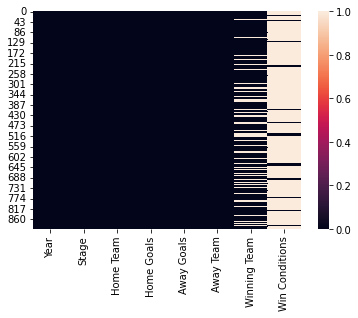

In [5]:
# Checking for missing values

sns.heatmap(df_world_cup_matches.isna())

pd.isnull(df_world_cup_matches).sum()

### Data Cleaning

In [6]:
# Auxiliar columns based on win conditions

df_world_cup_matches['aux1'] = df_world_cup_matches['Win Conditions'].str.split("win", expand=True)[0]
df_world_cup_matches['aux1'] = df_world_cup_matches['aux1'].str.replace(' ', '')

df_world_cup_matches['aux2'] = df_world_cup_matches['Win Conditions'].str.split("win", expand=True)[1]
df_world_cup_matches['aux2'] = df_world_cup_matches['aux2'].str.replace(' ', '')

In [7]:
# Remove missing Winning Team
df_world_cup_matches = df_world_cup_matches.dropna(subset=['Winning Team'])

# Remove leading and trailing whitespace
df_world_cup_matches['Winner'] = df_world_cup_matches['Winning Team'].str.strip()

# Adjusting winner column to Categorical
# 0: Team A
# 1: Team B
df_world_cup_matches['Winner'] = np.where(
    df_world_cup_matches['Winner'] == df_world_cup_matches['Home Team'], 0, 1
)

df_world_cup_matches.tail()

<ipython-input-7-8ae4b28a91a4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_world_cup_matches['Winner'] = df_world_cup_matches['Winning Team'].str.strip()
<ipython-input-7-8ae4b28a91a4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_world_cup_matches['Winner'] = np.where(


,Year,Stage,Home Team,Home Goals,Away Goals,Away Team,Winning Team,Win Conditions,aux1,aux2,Winner
894,2018,Quarter-finals,Sweden,0,2,England,England,NaN,NaN,NaN,1
896,2018,Semi-finals,France,1,0,Belgium,France,NaN,NaN,NaN,0
897,2018,Semi-finals,Croatia,2,1,England,Croatia,Extra time,Extratime,None,0
898,2018,Third place,Belgium,2,0,England,Belgium,NaN,NaN,NaN,0
899,2018,Final,France,4,2,Croatia,France,NaN,NaN,NaN,0


### Data Engineering

In [8]:
# Creating new variables for Penalties

df_world_cup_matches['Won on Penalties'] = np.where(
    df_world_cup_matches['aux2'].str.contains("penalties", case=False, na=False), 1, 0
)

df_world_cup_matches['Home Penalties'] = np.where(
    df_world_cup_matches['Won on Penalties'] != 0, 
    df_world_cup_matches['aux2'].str.slice(12, 13), #if true 
    0 #if false
)
df_world_cup_matches['Home Penalties'] = df_world_cup_matches['Home Penalties'].apply(int)

df_world_cup_matches['Away Penalties'] = np.where(
    df_world_cup_matches['Won on Penalties'] != 0, 
    df_world_cup_matches['aux2'].str.slice(14, 15), #if true 
    0 #if false
)
df_world_cup_matches['Away Penalties'] = df_world_cup_matches['Away Penalties'].apply(int)

df_world_cup_matches.tail()

,Year,Stage,Home Team,Home Goals,Away Goals,Away Team,Winning Team,Win Conditions,aux1,aux2,Winner,Won on Penalties,Home Penalties,Away Penalties
894,2018,Quarter-finals,Sweden,0,2,England,England,NaN,NaN,NaN,1,0,0,0
896,2018,Semi-finals,France,1,0,Belgium,France,NaN,NaN,NaN,0,0,0,0
897,2018,Semi-finals,Croatia,2,1,England,Croatia,Extra time,Extratime,None,0,0,0,0
898,2018,Third place,Belgium,2,0,England,Belgium,NaN,NaN,NaN,0,0,0,0
899,2018,Final,France,4,2,Croatia,France,NaN,NaN,NaN,0,0,0,0


In [9]:
# Drop unnecessary columns
df_world_cup_matches.drop(columns=['Winning Team','Win Conditions','aux1','aux2'], inplace=True)

In [10]:
# Check data types
print(df_world_cup_matches.info(), "\n")

# Check Nulls
print(pd.isnull(df_world_cup_matches).sum(), "\n")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701 entries, 0 to 899
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              701 non-null    int64 
 1   Stage             701 non-null    object
 2   Home Team         701 non-null    object
 3   Home Goals        701 non-null    int64 
 4   Away Goals        701 non-null    int64 
 5   Away Team         701 non-null    object
 6   Winner            701 non-null    int64 
 7   Won on Penalties  701 non-null    int64 
 8   Home Penalties    701 non-null    int64 
 9   Away Penalties    701 non-null    int64 
dtypes: int64(7), object(3)
memory usage: 60.2+ KB
None 

Year                0
Stage               0
Home Team           0
Home Goals          0
Away Goals          0
Away Team           0
Winner              0
Won on Penalties    0
Home Penalties      0
Away Penalties      0
dtype: int64 



In [11]:
display(df_world_cup_matches.head())
display(df_world_cup_matches.tail())

,Year,Stage,Home Team,Home Goals,Away Goals,Away Team,Winner,Won on Penalties,Home Penalties,Away Penalties
0,1930,Group stage,France,4,1,Mexico,0,0,0,0
1,1930,Group stage,United States,3,0,Belgium,0,0,0,0
2,1930,Group stage,Yugoslavia,2,1,Brazil,0,0,0,0
3,1930,Group stage,Romania,3,1,Peru,0,0,0,0
4,1930,Group stage,Argentina,1,0,France,0,0,0,0


,Year,Stage,Home Team,Home Goals,Away Goals,Away Team,Winner,Won on Penalties,Home Penalties,Away Penalties
894,2018,Quarter-finals,Sweden,0,2,England,1,0,0,0
896,2018,Semi-finals,France,1,0,Belgium,0,0,0,0
897,2018,Semi-finals,Croatia,2,1,England,0,0,0,0
898,2018,Third place,Belgium,2,0,England,0,0,0,0
899,2018,Final,France,4,2,Croatia,0,0,0,0


In [12]:
# Now we are going to convert the stages into numbers, so we can plot a **scatterplot** with goals. This way we can understand the performance of each team throughout the Cup
df_world_cup_matches['Stage'].unique()

array(['Group stage', 'Semi-finals', 'Final', 'Round of 16',
       'Quarter-finals', 'Third place', 'First round', 'Final round',
       'First group stage', 'Second group stage'], dtype=object)

In [13]:
# Dictionary to help understand and sort Stages

stages_dict = {
    'First group stage'     : "01_First_Group_Stage", 
    'First round'           : "02_First_Round",
    'Second group stage'    : "03_Second_Group_Stage", 
    'Final round'           : "04_Final_Round",
    'Group stage'           : "05_Group_Stage", 
    'Round of 16'           : "06_Round_16",
    'Quarter-finals'        : "07_Quarter_Finals",    
    'Semi-finals'           : "08_Semi_Finals",   
    'Third place'           : "09_Third_Place",   
    'Final'                 : "10_Final",
}

df_world_cup_matches.replace({'Stage': stages_dict}, inplace = True)
df_world_cup_matches = df_world_cup_matches.sort_values(by=['Year','Stage','Winner']).reset_index(drop = True)
df_world_cup_matches.tail(15)

,Year,Stage,Home Team,Home Goals,Away Goals,Away Team,Winner,Won on Penalties,Home Penalties,Away Penalties
686,2018,05_Group_Stage,Senegal,0,1,Colombia,1,0,0,0
687,2018,05_Group_Stage,Panama,1,2,Tunisia,1,0,0,0
688,2018,05_Group_Stage,England,0,1,Belgium,1,0,0,0
689,2018,06_Round_16,France,4,3,Argentina,0,0,0,0
690,2018,06_Round_16,Uruguay,2,1,Portugal,0,0,0,0
691,2018,06_Round_16,Brazil,2,0,Mexico,0,0,0,0
692,2018,06_Round_16,Belgium,3,2,Japan,0,0,0,0
693,2018,06_Round_16,Sweden,1,0,Switzerland,0,0,0,0
694,2018,07_Quarter_Finals,Uruguay,0,2,France,1,0,0,0
695,2018,07_Quarter_Finals,Brazil,1,2,Belgium,1,0,0,0


Visualizing data on our **final dataset**

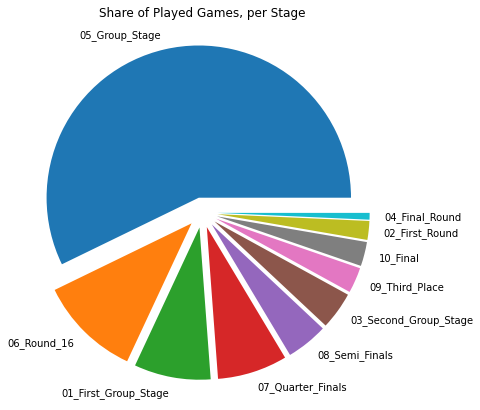

In [14]:
# Get the value counts for the 'Stage' column
stage_counts = df_world_cup_matches['Stage'].value_counts()

# Create a larger figure
plt.figure(figsize=(7, 7))

# Create a donut chart with larger labels and all the slices equally separated
plt.pie(stage_counts, labels=stage_counts.index, explode=[0.1] * len(stage_counts))
plt.title('Share of Played Games, per Stage')
plt.show()

Each time the top 10 FIFA Ranking 2022 reached each stage across all editions

In [26]:
# Home Team
countsH = df_world_cup_matches.groupby(['Home Team', 'Stage']).agg(count=('Stage', 'count')).reset_index(level = 1).reset_index()
countsH.rename(columns={'Home Team':'Team'}, inplace = True)

# Away Team
countsA = df_world_cup_matches.groupby(['Away Team', 'Stage']).agg(count=('Stage', 'count')).reset_index(level = 1).reset_index()
countsA.rename(columns={'Away Team':'Team'}, inplace = True)

df_count_of_stages_by_team = countsH.append(countsA)
df_count_of_stages_by_team = df_count_of_stages_by_team.groupby(['Team','Stage'])['count'].sum().reset_index()
del countsH, countsA

In [33]:
top_10 = world_cup_groups['Team'].head(10).tolist()
print(top_10)

# Filter only top 10 FIFA 2022 Ranking teams
df_count_of_stages_by_team = df_count_of_stages_by_team.loc[df_count_of_stages_by_team['Team'].isin(top_10)]

['Brazil', 'Belgium', 'Argentina', 'France', 'England', 'Spain', 'Netherlands', 'Portugal', 'Denmark', 'Germany']


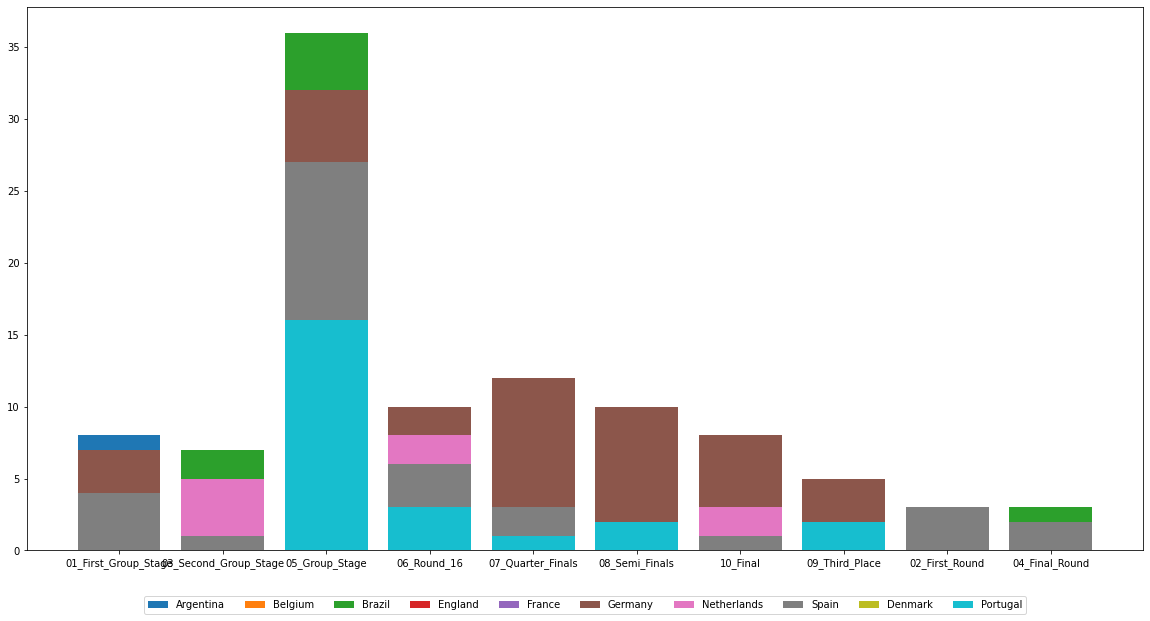

In [44]:
# Create a bar plot
plt.figure(figsize=(20,10))

for team in df_count_of_stages_by_team['Team'].unique():
    team_df = df_count_of_stages_by_team[df_count_of_stages_by_team['Team'] == team]
    plt.bar(team_df['Stage'], team_df['count'], label=team)

# Show the plot
plt.legend(
    bbox_to_anchor=(0.5,-0.1), 
    loc=10, 
    ncol=len(df_count_of_stages_by_team['Team'].unique())
)
plt.show()

# Model Development

## Encoding categorical columns

In [49]:
df_world_cup_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              701 non-null    int64 
 1   Stage             701 non-null    object
 2   Home Team         701 non-null    object
 3   Home Goals        701 non-null    int64 
 4   Away Goals        701 non-null    int64 
 5   Away Team         701 non-null    object
 6   Winner            701 non-null    int64 
 7   Won on Penalties  701 non-null    int64 
 8   Home Penalties    701 non-null    int64 
 9   Away Penalties    701 non-null    int64 
dtypes: int64(7), object(3)
memory usage: 54.9+ KB


In [50]:
#categorical data
categorical_cols = ['Stage', 'Home Team', 'Away Team'] 

#import pandas as pd
df = pd.get_dummies(df_world_cup_matches, columns = categorical_cols)

In [51]:
column_to_move = df.pop("Winner")
df.insert(len(df.columns), "Winner", column_to_move)
df.tail(10)

,Year,Home Goals,Away Goals,Won on Penalties,Home Penalties,Away Penalties,Stage_01_First_Group_Stage,Stage_02_First_Round,Stage_03_Second_Group_Stage,Stage_04_Final_Round,...,Away Team_Trinidad and Tobago,Away Team_Tunisia,Away Team_Turkey,Away Team_Ukraine,Away Team_United Arab Emirates,Away Team_United States,Away Team_Uruguay,Away Team_Wales,Away Team_Yugoslavia,Winner
691,2018,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
692,2018,3,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
693,2018,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
694,2018,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
695,2018,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
696,2018,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
697,2018,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
698,2018,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
699,2018,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
700,2018,4,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
#split dataset in features and target variable

X = df.loc[:, df.columns != 'Winner']   # Features
y = df.Winner                           # Target variable

In [99]:
print(X.shape)
X.tail()

(701, 170)


,Year,Home Goals,Away Goals,Won on Penalties,Home Penalties,Away Penalties,Stage_01_First_Group_Stage,Stage_02_First_Round,Stage_03_Second_Group_Stage,Stage_04_Final_Round,...,Away Team_Togo,Away Team_Trinidad and Tobago,Away Team_Tunisia,Away Team_Turkey,Away Team_Ukraine,Away Team_United Arab Emirates,Away Team_United States,Away Team_Uruguay,Away Team_Wales,Away Team_Yugoslavia
696,2018,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697,2018,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
698,2018,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
699,2018,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
700,2018,4,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
y

0      0
1      0
2      0
3      0
4      0
      ..
696    1
697    0
698    0
699    0
700    0
Name: Winner, Length: 701, dtype: int64

## Splitting data into Train and Test

To understand model performance, dividing the dataset into a training set and a test set is necessary.

Let's split the dataset by using function `train_test_split()`.

In [55]:
# Split dataset into 70% training and 30% for test

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.3, 
    random_state = 1
)

## Building the model


In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
# Initialize the model
model = RandomForestClassifier()

In [75]:
# train the model using the fit() method
model.fit(X_train, y_train)

RandomForestClassifier()

In [76]:
# make predictions on the test data
y_pred = model.predict(X_test)

## Model evaluation

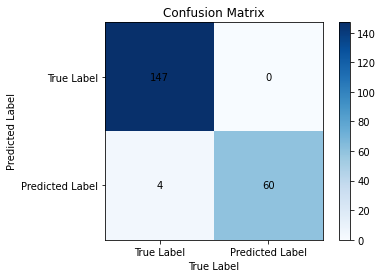

In [78]:
# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix as a heatmap
plt.imshow(cm, cmap='Blues')

# remove the grid lines inside the plot
plt.grid(which='both', linewidth=0)

plt.colorbar()

# add labels to the plot
tick_marks = [i for i in range(2)]
class_labels = ['True Label', 'Predicted Label']
plt.yticks(tick_marks, class_labels)
plt.xticks(tick_marks, class_labels)

# add a title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')

# add the values to the plot
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

# show the plot
plt.show()

**True positive (TP):**
<br>This is the number of cases where the model **correctly** predicted the positive class.

**False positive (FP):**
<br>This is the number of cases where the model incorrectly predicted the positive class.

**False negative (FN):**
<br>This is the number of cases where the model incorrectly predicted the negative class.

**True negative (TN):**
<br>This is the number of cases where the model **correctly** predicted the negative class.

In [77]:
# calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# calculate the precision of the model
precision = precision_score(y_test, y_pred)

# calculate the recall of the model
recall = recall_score(y_test, y_pred)

# calculate the f1 score of the model
f1 = f1_score(y_test, y_pred)

# print the evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.981
Precision: 1.000
Recall: 0.938
F1 score: 0.968


- **Accuracy:** Proportion of correct predictions made by the model. It is calculated by dividing the number of correct predictions by the total number of predictions.
<br>
- **Precision:** Proportion of positive predictions that are actually correct. It is calculated by dividing the number of true positives (TP) by the sum of the true positives and false positives (FP).
<br>
- **Recall:** Proportion of actual positive cases that were correctly predicted by the model. It is calculated by dividing the number of true positives by the sum of the true positives and false negatives (FN).
<br>
- **F1 score:** The F1 score is a measure of a model's balance between precision and recall. The F1 score ranges from 0 to 1, with a higher value indicating better performance.

## Plotting the Tree

In [94]:
n_estimators = model.n_estimators
print(f"Number of estimators: {n_estimators}")

Number of estimators: 100


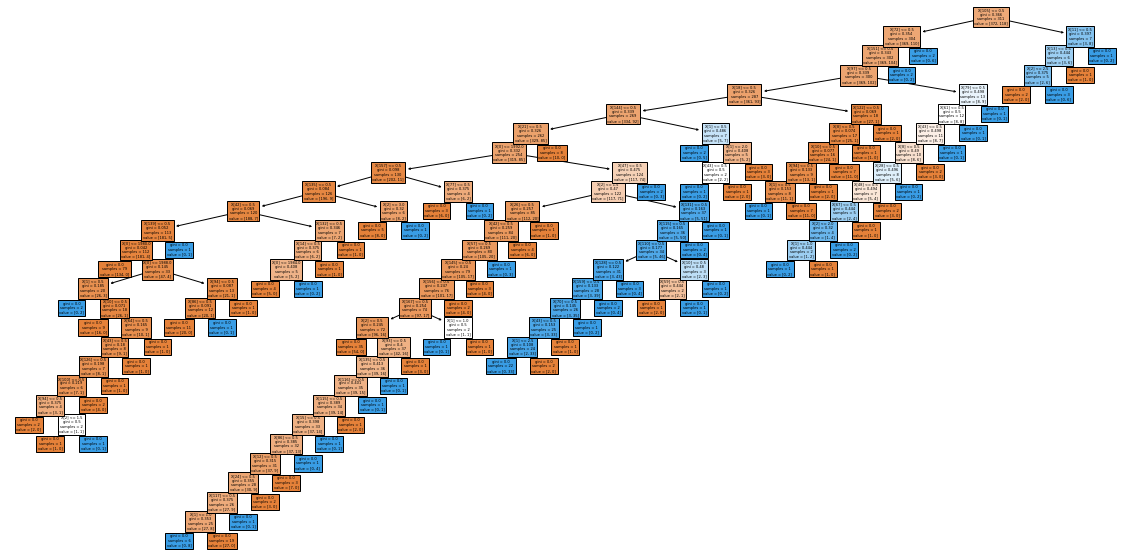

In [93]:
# Plot the first decision tree in the Random Forest

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], filled=True)
plt.show()

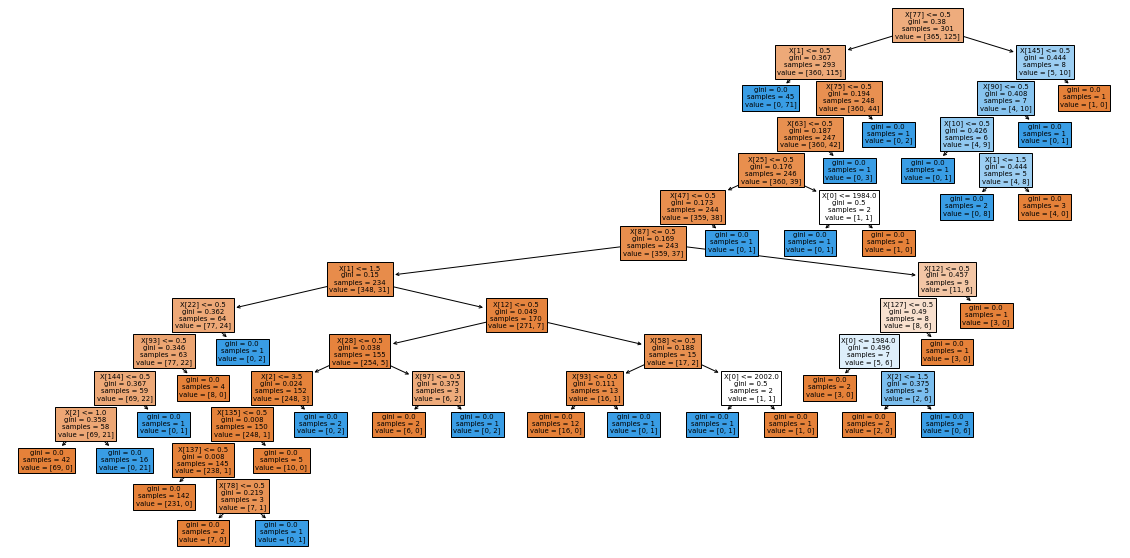

In [95]:
# Plot the last decision tree in the Random Forest

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[-1], filled=True)
plt.show()

# Model Deployment

In [119]:
df_cup_2022 = d['2022_world_cup_matches']
df_cup_2022 = df_cup_2022[['Year','Stage', 'Home Team', 'Away Team']].copy()

df_cup_2022['Home Goals']   = 0
df_cup_2022['Away Penalties']   = 0
df_cup_2022['Won on Penalties'] = 0
df_cup_2022['Home Penalties']   = 0
df_cup_2022['Away Penalties']   = 0

# Rename the Stages
df_cup_2022.replace({'Stage': stages_dict}, inplace = True)

In [121]:
df_cup_2022.head(5)

,Year,Stage,Home Team,Away Team,Home Goals,Away Penalties,Won on Penalties,Home Penalties
0,2022,05_Group_Stage,Qatar,Ecuador,0,0,0,0
1,2022,05_Group_Stage,Senegal,Netherlands,0,0,0,0
2,2022,05_Group_Stage,England,Iran,0,0,0,0
3,2022,05_Group_Stage,United States,Wales,0,0,0,0
4,2022,05_Group_Stage,France,Australia,0,0,0,0


In [122]:
# Get a list of the unique values in the 'Stage' column
stages = df_cup_2022['Stage'].unique()

# Split the data into a dictionary of DataFrames, 
# with one DataFrame for each unique value in the 'Stage' column
stage_dfs = {stage: df_cup_2022[df_cup_2022['Stage'] == stage] for stage in stages}

for key, value in stage_dfs.items():
    print(key)

05_Group_Stage
06_Round_16
07_Quarter_Finals
08_Semi_Finals
09_Third_Place
10_Final


In [131]:
df_05 = stage_dfs['05_Group_Stage']
df_05.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              48 non-null     int64 
 1   Stage             48 non-null     object
 2   Home Team         48 non-null     object
 3   Away Team         48 non-null     object
 4   Home Goals        48 non-null     int64 
 5   Away Penalties    48 non-null     int64 
 6   Won on Penalties  48 non-null     int64 
 7   Home Penalties    48 non-null     int64 
dtypes: int64(5), object(3)
memory usage: 3.4+ KB
